In [83]:
#Load modules
import datacube
import numpy as np
import xarray as xr
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import sys
from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.virtual import construct_from_yaml
import datacube

dc = datacube.Datacube()

def run_yaml_load(query):
    prod = construct_from_yaml("""
    transform: expressions
    output:
        Wetness_Tasseled :
            formula: 0.0315 * blue + 0.2021 * green + 0.3102 * red + 0.1594 * nir + -0.6806 * swir1 + -0.6109 * swir2
            dtype: float32
            nodata: -999
    input:
        transform: apply_mask
        mask_measurement_name: pixelquality
        input:
            transform: make_mask
            flags:
                cloud_acca: no_cloud
                cloud_fmask: no_cloud
                cloud_shadow_acca: no_cloud_shadow
                cloud_shadow_fmask: no_cloud_shadow
                blue_saturated: False
                green_saturated: False
                red_saturated: False
                nir_saturated: False
                swir1_saturated: False
                swir2_saturated: False
                contiguous: True 
            mask_measurement_name: pixelquality
            input:
                juxtapose:
                    - product: ls8_nbart_albers
                    - product: ls8_pq_albers

                    
    """)
    Data = prod.load(dc, **query)

    return Data

#Define load data module Landsat PQ
def get_landsat_PQ(query):
    sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
    #print('PQ data',sensor_pq)
    return (sensor_pq)


#define Save
def _save(ds, name):
    write_geotiff(name, ds)



output_file_path='/g/data/u46/users/ck9738/Datasets/Fisher_Tasselled_files/Test_out/yaml_pambula_test_1.tiff'

query = {

    # Mathoura Large
    # 'y': (-35.6545, -36.0320),
    # 'x': (144.8179, 145.4289),
    # lake dissapointment
    # 'y': (-23.2958, -23.410),
    # 'x': (123.0695, 123.230),
    # Pambula
    'y': (-36.900, -36.988),
    'x': (149.800, 149.925),


    'time': ('2017-01-01', '2017-12-31'),
    'crs': 'EPSG:4326',
    'output_crs': 'EPSG: 3577',
    'resolution': (-25, 25)
}

wet_summery = run_yaml_load(query)
want_to_mask = (wet_summery == -999).to_array(dim='variables').all(dim='variables')
wet_summery = wet_summery.where(~want_to_mask, np.NaN)
wet_summery

<xarray.Dataset>
Dimensions:           (time: 68, x: 498, y: 449)
Coordinates:
  * time              (time) datetime64[ns] 2017-01-07T23:50:53 ... 2017-12-25T23:51:16
  * y                 (y) float64 -4.144e+06 -4.144e+06 ... -4.155e+06
  * x                 (x) float64 1.585e+06 1.585e+06 ... 1.597e+06 1.597e+06
Data variables:
    Wetness_Tasseled  (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    Fisher_index      (time, y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    crs:      EPSG: 3577

(array([9.000000e+00, 9.000000e+00, 2.800000e+01, 3.300000e+01,
        2.397000e+03, 9.864300e+04, 1.971036e+06, 7.185744e+06,
        4.629300e+04, 2.145000e+03]),
 array([-12217.028  , -10624.662  ,  -9032.296  ,  -7439.9297 ,
         -5847.5635 ,  -4255.1973 ,  -2662.8308 ,  -1070.4645 ,
           521.90173,   2114.268  ,   3706.6343 ], dtype=float32),
 <a list of 10 Patch objects>)

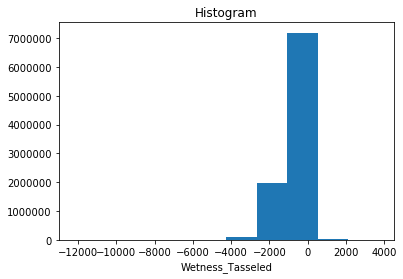

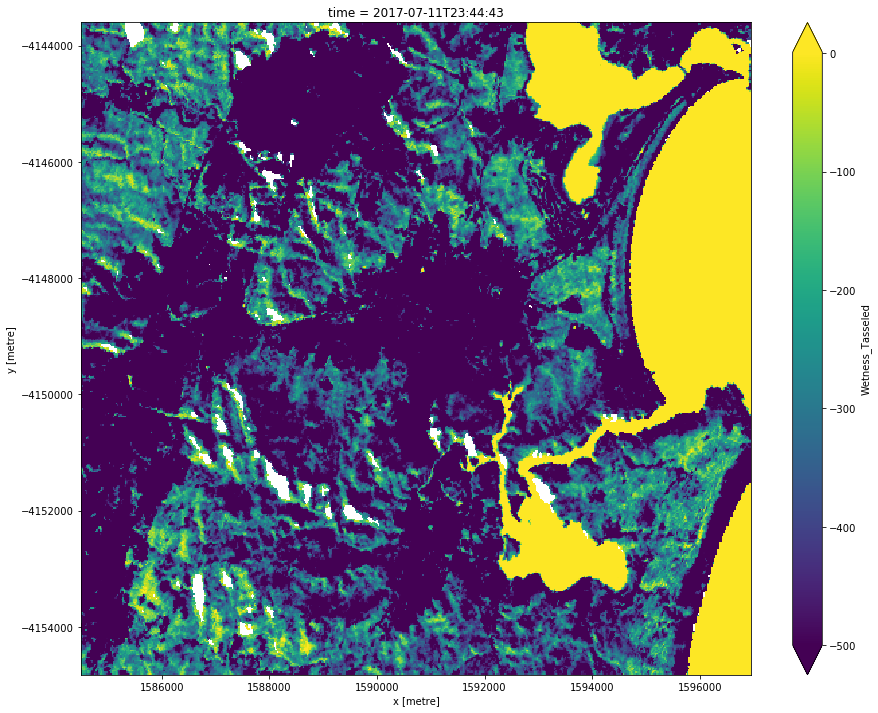

In [90]:
wet_summery.Wetness_Tasseled.isel(time=35).plot(cmap='viridis', figsize =(15,12),vmin=-500, vmax=1)

In [86]:
inundated_veg_msk = (np.logical_and(wet_summery.Fisher_index>=-10,wet_summery.Wetness_Tasseled>=-400))
inundated_veg = wet_summery.Fisher_index.where(inundated_veg_msk==True,0)
inundated_veg = inundated_veg.where(inundated_veg_msk==False,1)

In [87]:
wet_frequency = inundated_veg.sum(dim='time')

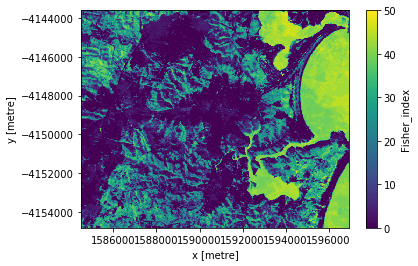

In [88]:
wet_frequency.plot()